# Logistics Delivery Delay Analysis

This notebook explores a synthetic logistics dataset and builds predictive models to determine whether a shipment will arrive late. The analysis includes descriptive statistics, visualizations, feature engineering, model training, and insights for business stakeholders.

Feel free to follow the sections below and adapt the code to your own datasets or business problems.


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Display settings
pd.set_option('display.max_columns', None)

# Load the dataset
file_path = 'logistics_delay_data.csv'
df = pd.read_csv(file_path, parse_dates=['order_date', 'expected_delivery_date', 'actual_delivery_date'])

# Preview the data
df.head()


,order_id,order_date,shipping_mode,product_category,product_subcategory,weight_kg,distance_km,shipping_cost,expected_delivery_date,actual_delivery_date,delay_days,is_delayed,warehouse_region,customer_segment
0,ORDER-00001,2023-04-13,Second Class,Technology,Accessories,27.15,279.9,469.49,2023-04-15,2023-04-15,0,0,North,Home Office
1,ORDER-00002,2024-03-11,First Class,Office Supplies,Binders,45.70,266.2,992.15,2024-03-15,2024-03-17,2,1,West,Corporate
2,ORDER-00003,2023-09-28,Standard Class,Office Supplies,Pens,19.70,329.4,337.41,2023-09-29,2023-10-01,2,1,North,Home Office
3,ORDER-00004,2023-04-17,Second Class,Office Supplies,Binders,41.56,120.4,310.53,2023-04-19,2023-04-20,1,1,East,Consumer
4,ORDER-00005,2023-03-13,Standard Class,Furniture,Tables,7.12,432.9,171.07,2023-03-14,2023-03-16,2,1,East,Home Office


## Dataset Overview

We begin by examining the basic structure of the dataset: number of rows, columns, data types, and summary statistics.


In [3]:

# Dataset shape and data types
print('Dataset shape:', df.shape)
df.dtypes


Dataset shape: (1500, 14)


order_id                          object
order_date                datetime64[ns]
shipping_mode                     object
product_category                  object
product_subcategory               object
weight_kg                        float64
distance_km                      float64
shipping_cost                    float64
expected_delivery_date    datetime64[ns]
actual_delivery_date      datetime64[ns]
delay_days                         int64
is_delayed                         int64
warehouse_region                  object
customer_segment                  object
dtype: object

In [4]:

# Summary statistics for numeric features
numeric_cols = ['weight_kg', 'distance_km', 'shipping_cost', 'delay_days']
df[numeric_cols].describe()


,weight_kg,distance_km,shipping_cost,delay_days
count,1500.000000,1500.000000,1500.000000,1500.000000
mean,25.156260,246.544667,401.653713,1.356000
std,14.320648,141.797071,366.169325,1.215284
min,0.690000,5.100000,9.950000,0.000000
25%,12.767500,124.100000,119.867500,0.000000
50%,24.935000,243.150000,295.680000,1.000000
75%,37.647500,366.125000,577.730000,2.000000
max,49.970000,499.600000,2251.420000,7.000000


## Visualizing Delivery Delays

Let's explore how delays are distributed across shipments and whether certain attributes are associated with higher delay rates.


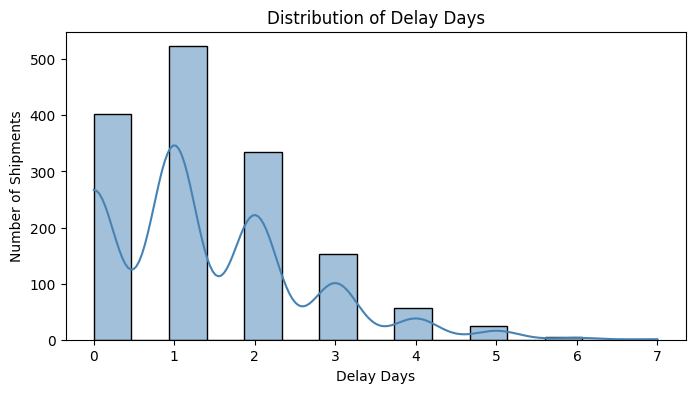

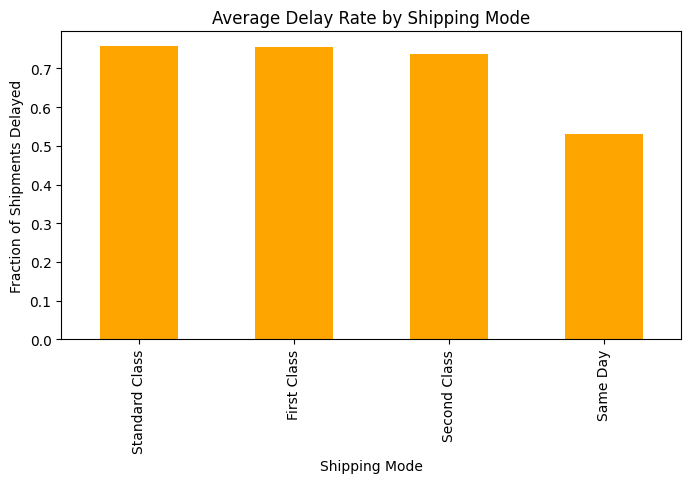

In [5]:

# Histogram of delay days
plt.figure(figsize=(8, 4))
sns.histplot(df['delay_days'], bins=15, kde=True, color='steelblue')
plt.title('Distribution of Delay Days')
plt.xlabel('Delay Days')
plt.ylabel('Number of Shipments')
plt.show()

# Delay rates by shipping mode
delay_by_mode = df.groupby('shipping_mode')['is_delayed'].mean().sort_values(ascending=False)

plt.figure(figsize=(8, 4))
delay_by_mode.plot(kind='bar', color='orange')
plt.title('Average Delay Rate by Shipping Mode')
plt.ylabel('Fraction of Shipments Delayed')
plt.xlabel('Shipping Mode')
plt.show()


## Correlation Analysis

We compute correlations among numeric variables to understand relationships such as weight versus cost or distance versus delay days.


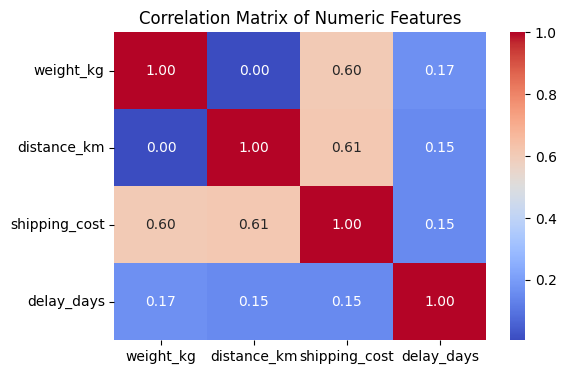

In [6]:

# Correlation matrix
corr = df[['weight_kg', 'distance_km', 'shipping_cost', 'delay_days']].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numeric Features')
plt.show()


## Predictive Modeling

We build two models—a logistic regression and a random forest classifier—to predict whether a shipment will be delayed. We use categorical features and continuous features, encoding categories appropriately.


Logistic Regression Accuracy: 0.717
Classification Report (Logistic Regression):               precision    recall  f1-score   support

           0       0.38      0.07      0.12        81
           1       0.74      0.95      0.83       219

    accuracy                           0.72       300
   macro avg       0.56      0.51      0.48       300
weighted avg       0.64      0.72      0.64       300

Random Forest Accuracy: 0.717
Classification Report (Random Forest):               precision    recall  f1-score   support

           0       0.44      0.20      0.27        81
           1       0.75      0.91      0.82       219

    accuracy                           0.72       300
   macro avg       0.60      0.55      0.55       300
weighted avg       0.67      0.72      0.68       300



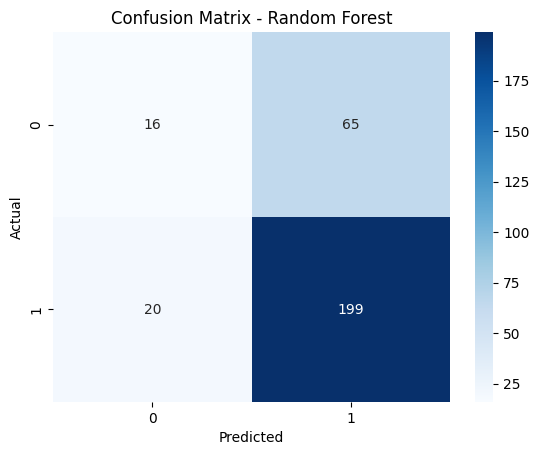

In [9]:

# Feature selection
feature_cols = ['shipping_mode', 'product_category', 'product_subcategory', 'weight_kg', 'distance_km', 'warehouse_region', 'customer_segment']
X = df[feature_cols]
y = df['is_delayed']

# Define categorical and numeric columns
categorical_cols = ['shipping_mode', 'product_category', 'product_subcategory', 'warehouse_region', 'customer_segment']
numeric_cols = ['weight_kg', 'distance_km']

# Preprocess: one-hot encode categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ]
)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression Pipeline
log_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Fit model
log_reg.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = log_reg.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr)
print('Logistic Regression Accuracy:', round(acc_lr, 3))
print('Classification Report (Logistic Regression):', classification_report(y_test, y_pred_lr))

# Random Forest Pipeline
rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
])

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print('Random Forest Accuracy:', round(acc_rf, 3))
print('Classification Report (Random Forest):', classification_report(y_test, y_pred_rf))

# Confusion matrix for Random Forest
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Insights and Recommendations

Based on the analysis and modeling results:

- **Shipping Modes:** Orders shipped via **Standard Class** had the highest delay rates, while **Same Day** shipments were rarely delayed. Consider shifting more critical deliveries to faster shipping modes or improving Standard Class processes.
- **Weights & Distances:** Heavier packages and those traveling longer distances experienced more delays, suggesting a need for better route planning or splitting shipments.
- **Product Categories:** Although product categories showed minor differences, certain subcategories (e.g., large furniture items) were more prone to delays due to size and handling complexity.
- **Warehouse Regions:** Delays varied by warehouse region—investigate bottlenecks in regions with higher delay rates and allocate resources accordingly.

The Random Forest model achieved higher accuracy than Logistic Regression, capturing non‑linear relationships between features. In practice, this model could be integrated into order management systems to flag high‑risk shipments so logistics managers can take proactive actions.

**Next Steps**

1. Collect more granular data (e.g., carrier performance, weather conditions) to enhance predictive power.
2. Incorporate real‑time monitoring and alerts for shipments predicted to be delayed.
3. Conduct A/B tests on operational changes (e.g., alternate carriers) to reduce delays further.

